/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu
/usr/lib/python3/dist-packages/scipy/stats/_distn_infrastructure.py:2640: RuntimeWarning: invalid value encountered in multiply
  Lhat = muhat - Shat*mu


             date    price   returns  absreturn  survival
8650   1990-10-06  2739.00 -0.688023   0.688023      0.02
13250  1974-11-08   191.39 -0.403355   0.403355      0.04
8750   1990-05-31  7290.00 -0.366014   0.366014      0.06
9450   1987-12-14  2715.20 -0.332344   0.332344      0.08
5800   2000-11-21  5103.00 -0.303161   0.303161      0.10
Taiwan stock index N 311 MS 0.26
             date    price   returns  absreturn  survival
7850   1987-10-29   244.77 -0.298258   0.298258  0.033333
2550   2008-11-04  1005.75 -0.230792   0.230792  0.066667
11350  1973-12-24    92.90 -0.181963   0.181963  0.100000
11150  1974-10-09    67.82 -0.171400   0.171400  0.133333
2500   2009-01-16   850.12 -0.168111   0.168111  0.166667
S&P500 stock index N 347 MS 0.21
Gaussian with same σ as TAIEX mean 0.000347 stdev 0.014374
Gaussian with same σ as TAIEX N 311 MS 0.10


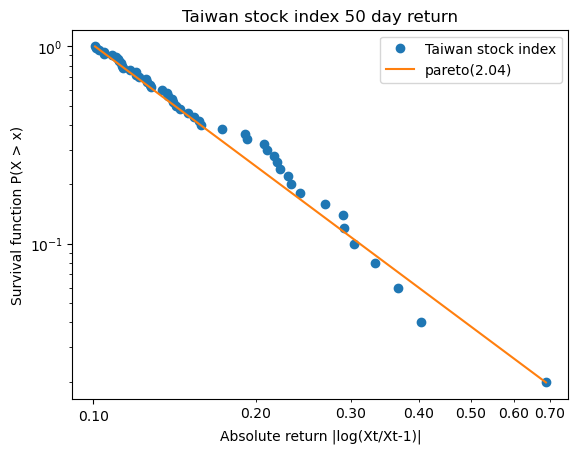

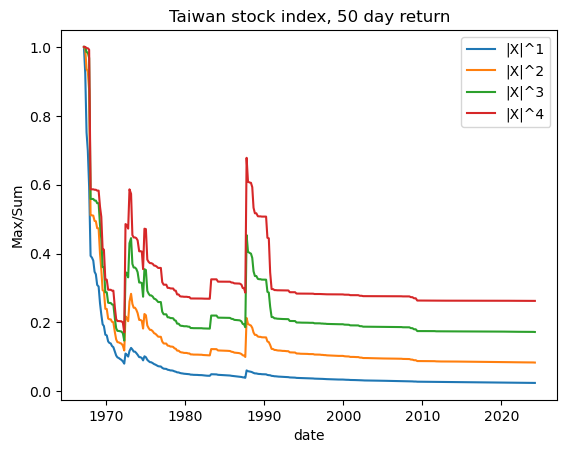

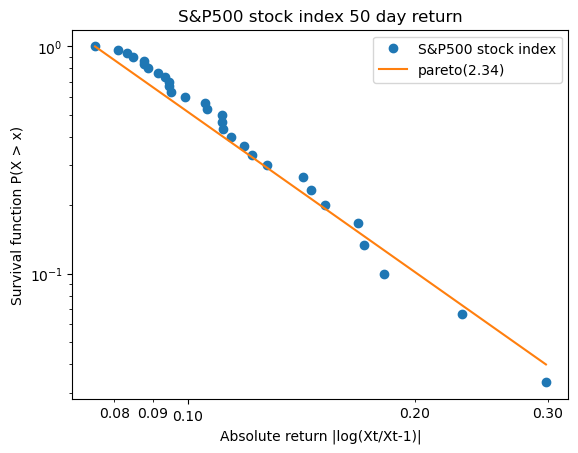

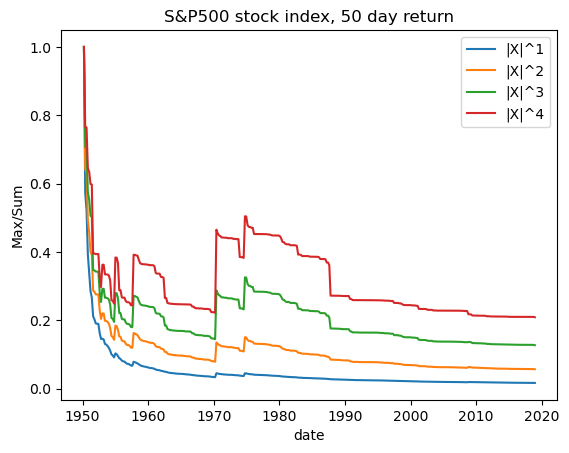

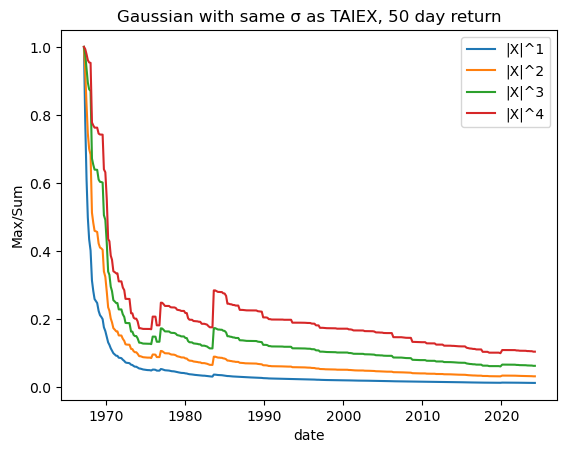

In [1]:
import sys

import numpy as np
import pandas
import scipy
import scipy.stats
import statsmodels
import statsmodels.tsa
import statsmodels.tsa.stattools
import matplotlib
import matplotlib.pyplot as plt


class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def analyzePareto(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    # df["returns"] = df.price / df.price.shift(-analysis.lag)-1
    # df.drop(df.tail(analysis.lag).index,inplace=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = df.price / df.price.shift(-1)-1
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]
    if len(df) == 0:
        return
    
    # Maximum likelihood method. 
    xm = np.min(df.absreturn)
    alpha = len(df)/np.sum(np.log(df.absreturn/xm))

    # Scipy method.
    scipyPareto = scipy.stats.pareto.fit(df.absreturn, scale=analysis.lag*0.02)
    scipyAlpha = scipyPareto[0]

    df = df.sort_values(by='absreturn', ascending=False)
    df["survival"] = 1-(df.absreturn.rank()-1) / len(df)
    fitted = np.power(xm/df.absreturn, alpha)
    
    print(df.head(5))
    fig, ax = plt.subplots(1, 1)
    ax.plot(df.absreturn.to_numpy(), df.survival.to_numpy(), "o", label=analysis.name)
    ax.plot(df.absreturn.to_numpy(), fitted.to_numpy(), label=("pareto(%.2f)"%(alpha)))
    ax.legend()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '%.2f' % x))
    ax.set_title("%s %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("Absolute return |log(Xt/Xt-1)|")
    ax.set_ylabel("Survival function P(X > x)")
    # fig.savefig("loglog_%s"%analysis.name)


def analyzeMSp(df, p):
    df["Xp%d" % p] = np.power(df.absreturn, p)

    df["msMax%d" % p] = df["Xp%d" % p].cummax()
    if False:
        k = 10
        for i in range(len(df)):
            subset = df.iloc[:i+1]
            vs = subset["Xp%d" % p].to_numpy().copy()
    
            vs = np.sort(vs)
            largest = vs[max(0, len(vs)-k):]
            mx = np.sum(largest)
    
            df.iloc[i, df.columns.get_loc("msMax%d" % p)] = mx
            
    
    df["msSum%d" % p] = df["Xp%d" % p].cumsum()
    df["ms%d" % p] = df["msMax%d" % p] / df["msSum%d" % p]


def plotMS(analysis, df):
    fig, ax = plt.subplots(1, 1)
    for p in [1, 2, 3, 4]:
        analyzeMSp(df, p)
        x = matplotlib.dates.date2num(df.date)
        y = df["ms%d" % p].to_numpy()
        x = x[0:]
        y = y[0:]
        ax.plot_date(x, y, fmt="-", label=("|X|^%d" % p))
    ax.legend()
    ax.set_title("%s, %d day return" % (analysis.name, analysis.lag))
    ax.set_xlabel("date")
    ax.set_ylabel("Max/Sum")
    # fig.savefig("ms_%s"%analysis.name)
    print("%s N %d MS %.2f" % (analysis.name, len(df), df.iloc[len(df)-1]["ms4"]))


def analyzeMS(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(1))
    df.drop(df.head(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))

    plotMS(analysis, df)
    #df.to_csv("qqq.csv")


def analyze(analysis):
    analyzePareto(analysis)
    analyzeMS(analysis)


# Plot a MS-plot for a normal distribution corresponding to TAIEX.
def ms_taiex_gaussian():
    analysis = Analysis()
    analysis.name = "Gaussian with same σ as TAIEX"
    analysis.lag = 50
    
    # Compute daily standard deviation
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)
    mean = np.mean(df.returns)
    std = np.std(df.returns)
    print("%s mean %f stdev %f" % (analysis.name, mean, std))
    
    # Simulate a normal distribution using the computed standard deviation.
    df = pandas.read_csv("taiex.csv", dtype={'price': np.float64})
    df = df.sort_values(by='date', ascending=True)
    df["returns"] = np.random.normal(loc=0, scale=std, size=len(df))
    for i in range(len(df)):
        if i == 0:
            continue
        lastPrice = df.iloc[i-1].price
        returnI = np.exp(df.iloc[i].returns)
        df.iloc[i, df.columns.get_loc("price")] = lastPrice*returnI

    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(1))
    df.drop(df.head(1).index,inplace=True)
    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    plotMS(analysis, df)


for lag in [50]:
    for tailCutoff in [0.002]:
        analysis = Analysis()
        analysis.name = "Taiwan stock index"
        analysis.fpath = "taiex.csv"
        analysis.lag = lag
        analysis.tailCutoff = tailCutoff
        analyze(analysis)
        
        analysis.name = "S&P500 stock index"
        analysis.fpath = "sp500.csv"
        analysis.tailCutoff = 0.0015
        analyze(analysis)
ms_taiex_gaussian()

In [2]:
def paretoWithVariance(alpha):
    scale = np.sqrt((alpha-1)*(alpha-1)*(alpha-2)/alpha)
    distribution = scipy.stats.pareto(alpha, scale=scale)
    return distribution


class PDF:
    def __init__(self, x, pdf):
        self.x = x
        self.pdf = pdf


def getPDF(data, bins):
    hist = np.histogram(data, bins=bins)
    x = (hist[1][:-1] + hist[1][1:])/2
    pdf = hist[0]/len(data)
    return PDF(x, pdf)


def varianceDistribution(analysis):
    runs = 10000
    size = int(analysis.mcSize / runs)
    variance = np.zeros((runs, size))
    for i in range(runs):
        data = np.reshape(analysis.distribution.rvs(analysis.sampleSize*size), (size, analysis.sampleSize))
        variance[i] = np.var(data, axis=1)
        if (i % (runs/100)) == 0:
            print("%s run %d" % (analysis.name, i))
    variance = np.reshape(variance, analysis.mcSize)
    
    pdfAll = getPDF(variance, analysis.bins)

    # Zoom into our expected area for the chi-square distribution.
    subset = variance[variance<3]
    pdf02 = getPDF(subset, analysis.bins)
    pdf02.pdf *= len(subset) / len(variance)

    print(analysis.upperSignificance)
    upper = np.percentile(variance, analysis.upperSignificance)
    
    return ((pdfAll, pdf02), upper)


def analyze(analysis):
    print("%s variance: %f"%(analysis.name, analysis.distribution.var()))
    
    pdfs, upper = varianceDistribution(analysis)

    for pdf in pdfs:
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 0, "%d%% percentile %.4f"%(analysis.upperSignificance, upper), horizontalalignment="center")
        ax.set_title("%s, variance distribution of sample size %d" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")
        
        fig, ax = plt.subplots(1, 1)
        ax.plot(pdf.x, pdf.pdf)
        ax.vlines(upper, 0, np.max(pdf.pdf), color="C1")
        ax.text(upper, 1e-3, "%d%% percentile %.4f"%(analysis.upperSignificance, upper))
        ax.set_xlim((1e-2, 3))
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title("%s, variance distribution of sample size %d, log-log plot" % (analysis.name, analysis.sampleSize))
        ax.set_xlabel("variance")
        ax.set_ylabel("probability")


class Analysis:
    def __init__(self, name, sampleSize, bins, mcSize, distribution):
        self.name = name
        self.sampleSize = sampleSize
        self.bins = bins
        self.mcSize = int(bins*mcSize)
        self.distribution = distribution
        self.upperSignificance = 95


bins = 100
# analyze(Analysis("gaussian", 311, bins, 1e4, scipy.stats.norm()))
alpha = 2.04
# analyze(Analysis("pareto %.2f"%alpha, 311, bins, 1e4, paretoWithVariance(alpha)))
# analyze(Analysis("pareto %.2f"%alpha, 1000000, bins, 1e3, paretoWithVariance(alpha)))

22 0.43656949966168135 2.3650683116879923 5.417392450734184
30 0.3907653337513779 2.0129468855891677 5.151293402269642


Text(0, 0.5, 'skewness')

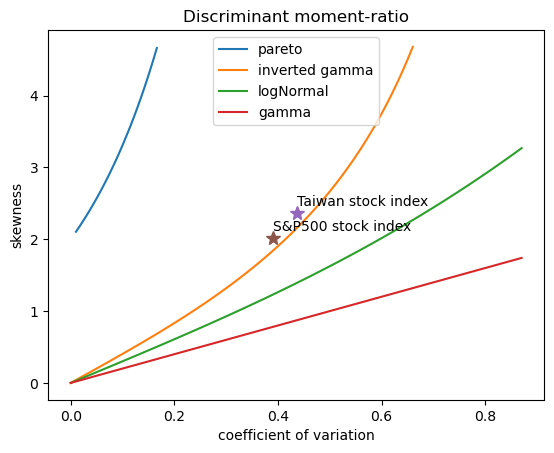

In [3]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001

        self.n = 0
        self.cv = 0
        self.skew = 0
        

def paretoCurve(maxX, maxY):
    p = np.concatenate([
        np.arange(3.01, 5, 0.01),
        np.arange(5.1, 10, 0.1),
        np.arange(10, 100, 1),
        ])
    x = 1/np.sqrt(p*(p-2))
    y = (1+p)/(p-3)*2/np.sqrt(1-2/p)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def invertedGammaCurve(maxX, maxY):
    gMaxX = min(1, maxX)
    n = 100
    
    x = np.arange(0, gMaxX-1/n, 1/n)
    y = 4*x/(1-x*x)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def logNormalCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    w = x*x + 1
    y = (w+2)*np.sqrt(w-1)

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def gammaCurve(maxX, maxY):
    n = 100
    
    x = np.arange(0, maxX, 1/n)
    y = 2*x

    points = []
    for i in range(len(x)):
        xi = x[i]
        yi = y[i]

        if xi < maxX and yi < maxY:
            points.append([xi, yi])
    
    return np.array(points)


def plotMomentRatio(ax, cv, skew):
    maxX = 2 * cv
    maxY = 2 * skew
    x = np.arange(0, maxX, maxX/100)
    
    pareto = paretoCurve(maxX, maxY)
    invertedGamma = invertedGammaCurve(maxX, maxY)
    logNormal = logNormalCurve(maxX, maxY)
    gamma = gammaCurve(maxX, maxY)

    ax.plot(pareto[:, 0], pareto[:, 1], label="pareto")
    ax.plot(invertedGamma[:, 0], invertedGamma[:, 1], label="inverted gamma")
    ax.plot(logNormal[:, 0], logNormal[:, 1], label="logNormal")
    ax.plot(gamma[:, 0], gamma[:, 1], label="gamma")


def analyzeMomentRatio(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    analysis.n = len(df)
    analysis.cv = np.std(df.absreturn) / np.mean(df.absreturn)
    analysis.skew = scipy.stats.skew(df.absreturn)

    print(analysis.n, analysis.cv, analysis.skew, analysis.skew/analysis.cv)


ans = []

analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = 50
analysis.tailCutoff = 0.003
analyzeMomentRatio(analysis)
ans.append(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = 50
analysis.tailCutoff = 0.0015
analyzeMomentRatio(analysis)
ans.append(analysis)

fig, ax = plt.subplots(1, 1)
plotMomentRatio(ax, np.max([a.cv for a in ans]), np.max([a.skew for a in ans]))
for analysis in ans:
    ax.plot(analysis.cv, analysis.skew, "*", markersize=10)
    ax.text(analysis.cv, analysis.skew+0.1, analysis.name)
ax.legend(loc="upper center")
ax.set_title("Discriminant moment-ratio")
ax.set_xlabel("coefficient of variation")
ax.set_ylabel("skewness")

48 48
28 28


/tmp/ipykernel_244728/952833897.py:17: RuntimeWarning: invalid value encountered in scalar divide
  eu = np.sum(larger-u) / len(larger)
/tmp/ipykernel_244728/952833897.py:17: RuntimeWarning: invalid value encountered in scalar divide
  eu = np.sum(larger-u) / len(larger)


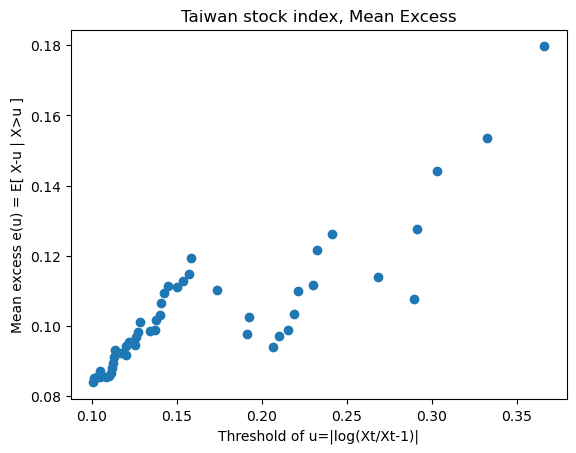

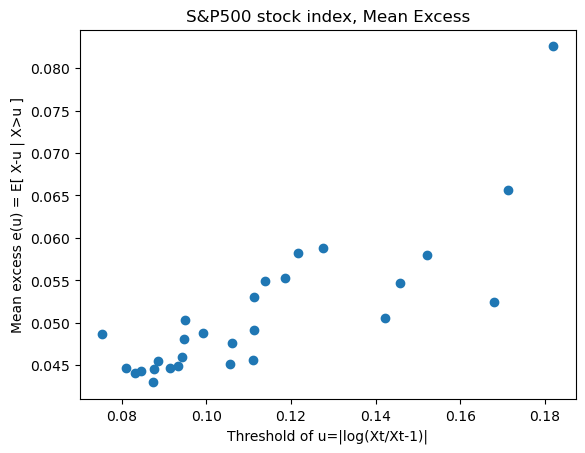

In [4]:
def analyzeME(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    orderedStats = np.sort(df.absreturn)
    excess = []
    for i in range(len(orderedStats)):
        u = orderedStats[i]
        larger = orderedStats[i+1:]
        eu = np.sum(larger-u) / len(larger)
        excess.append(eu)

    lastRemoveN = 2
    u = orderedStats[:len(orderedStats)-lastRemoveN]
    eu = np.array(excess)[:len(excess)-lastRemoveN]
    print(len(u), len(eu))

    fig, ax = plt.subplots(1, 1)
    ax.plot(u, eu, "o")
    ax.set_title("%s, Mean Excess"%(analysis.name))
    ax.set_xlabel("Threshold of u=|log(Xt/Xt-1)|")
    ax.set_ylabel("Mean excess e(u) = E[ X-u | X>u ]")


analysis = Analysis()
analysis.name = "Taiwan stock index"
analysis.fpath = "taiex.csv"
analysis.lag = 50
analysis.tailCutoff = 0.002
analyzeME(analysis)

analysis = Analysis()
analysis.name = "S&P500 stock index"
analysis.fpath = "sp500.csv"
analysis.lag = 50
analysis.tailCutoff = 0.0015
analyzeME(analysis)

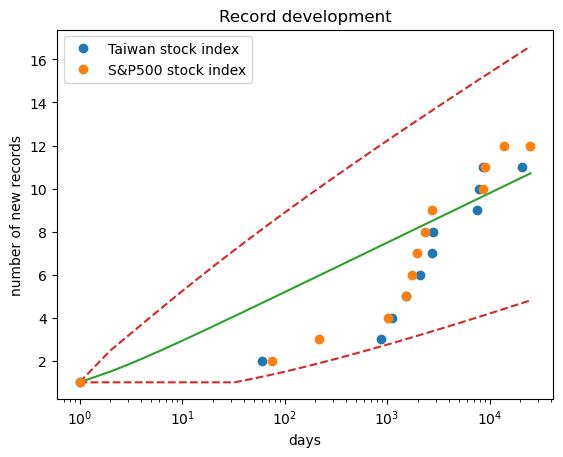

In [5]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001
        self.positive = True


def getData(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    #if analysis.positive:
    #    df = df[df.returns > 0]
    #else:
    #    df = df[df.returns < 0]
    # df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    df["date"] = pandas.to_datetime(df.date)
    df = df.sort_values(by='date', ascending=True)

    return df


def recordInterval(n, ci):
    res = []
    mean = 0
    var = 0
    for i in range(int(n)):
        i1 = i + 1
        
        mean += 1/i1
        var += (1/i1 - 1/i1/i1)
        res.append((i1, mean, np.max([1, mean-ci*np.sqrt(var)]), mean+ci*np.sqrt(var)))
    return pandas.DataFrame(np.array(res), columns=("n", "mu", "ll", "ul"))


def analyzeRecord(analysis):
    df = getData(analysis)

    firstDt = df.iloc[0].date.timestamp()
    mx = -sys.float_info.max
    numRecord = 0
    records = []
    for i in range(len(df)):
        dt = df.iloc[i].date.timestamp()
        days = (dt - firstDt)/86400
        v = df.iloc[i].absreturn

        got = False
        if v > mx:
            mx = v
            numRecord += 1
            got = True

        if got or (i == len(df)-1):
            rc = [i+1, days+1, dt, v, numRecord]
            records.append(rc)
            
    records = pandas.DataFrame(np.array(records), columns=("i", "days", "date", "v", "numRecord"))
    records["date"] = records.date.astype("datetime64[s]")
    return records


def analyzeRecordList(ass):
    records = []
    for analysis in ass:
        rcs = analyzeRecord(analysis)
        records.append(rcs)

    maxX = np.max([np.max(rcs.days) for rcs in records])
    ci = 1.96
    theory = recordInterval(maxX, ci)
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(theory.n.to_numpy(), theory.mu.to_numpy(), color="C%d"%len(records))
    ax.plot(theory.n.to_numpy(), theory.ll.to_numpy(), "--", color="C%d"%(len(records)+1))
    ax.plot(theory.n.to_numpy(), theory.ul.to_numpy(), "--", color="C%d"%(len(records)+1))
    for i, rcs in enumerate(records):
        analysis = ass[i]
        positive = "positive"
        if not analysis.positive:
            positive = "negative"
        ax.plot(rcs.days.to_numpy(), rcs.numRecord.to_numpy(), "o", label="%s"%(analysis.name,))
    ax.legend()
    ax.set_xscale("log")
    ax.set_title("Record development")
    ax.set_xlabel("days")
    ax.set_ylabel("number of new records")


ass = []
lag = 50
for isPositive in (False,):
    analysis = Analysis()
    analysis.name = "Taiwan stock index"
    analysis.fpath = "taiex.csv"
    analysis.lag = lag
    analysis.tailCutoff = 0.002
    analysis.positive = isPositive
    ass.append(analysis)
    
    analysis = Analysis()
    analysis.name = "S&P500 stock index"
    analysis.fpath = "sp500.csv"
    analysis.lag = lag
    analysis.tailCutoff = 0.0015
    analysis.positive = isPositive
    ass.append(analysis)

analyzeRecordList(ass)

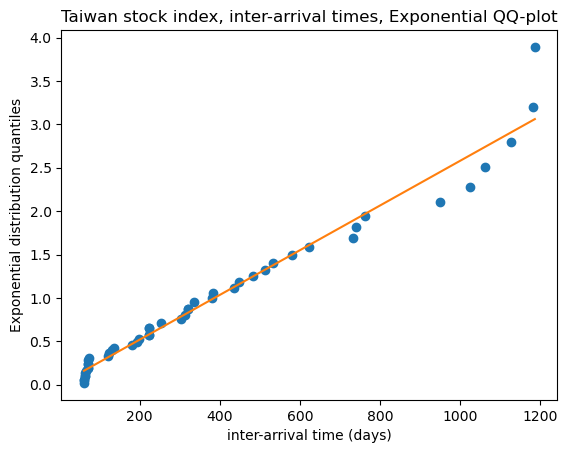

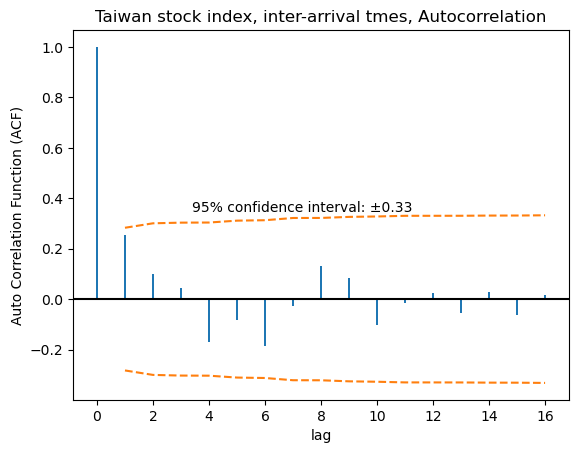

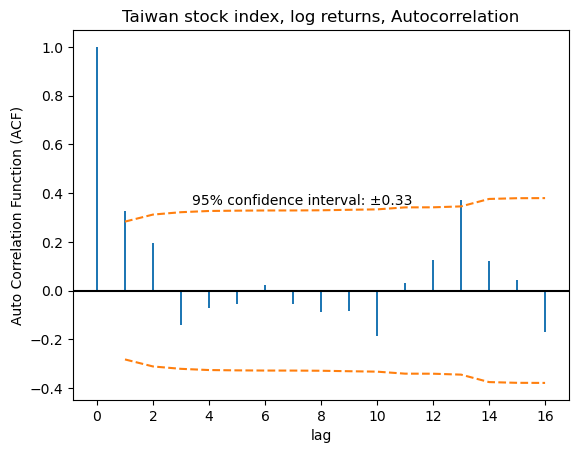

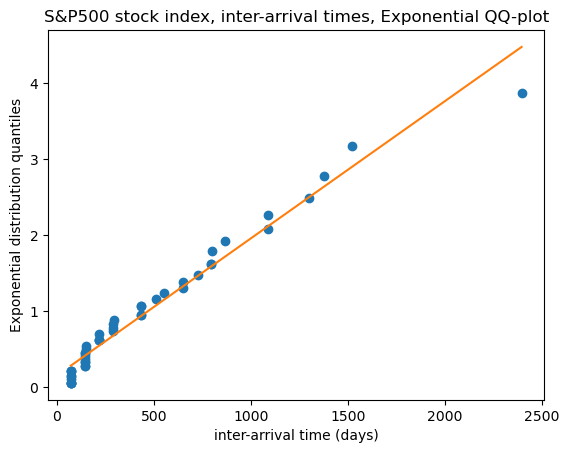

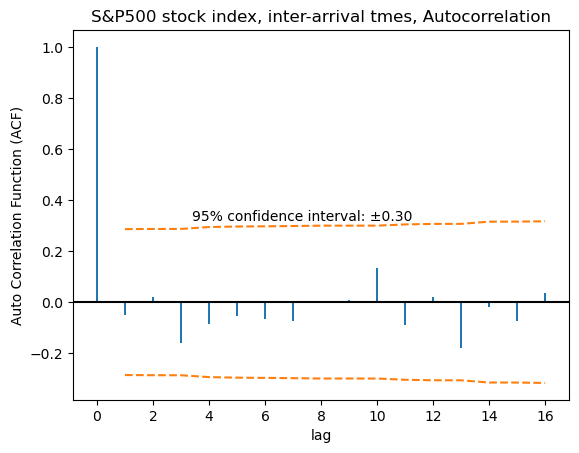

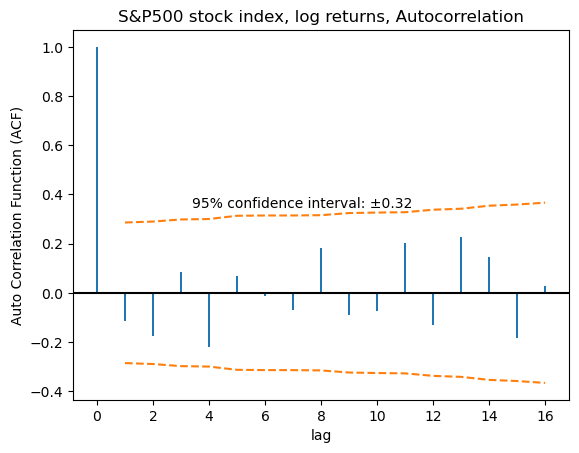

In [6]:
class Analysis:
    def __init__(self):
        self.name = ""
        self.fpath = ""

        self.lag = 1
        self.tailCutoff = 0.001


def getData(analysis):
    df = pandas.read_csv(analysis.fpath, dtype={'price': np.float64})
    
    df = df.iloc[::analysis.lag, :]
    df["returns"] = np.log(df.price / df.price.shift(-1))
    df.drop(df.tail(1).index,inplace=True)

    df["absreturn"] = df.returns.apply(lambda x: np.abs(x))
    df = df[df.returns < 0]
    df = df[(df.absreturn > analysis.lag*analysis.tailCutoff)]

    df["date"] = pandas.to_datetime(df.date)
    df = df.sort_values(by='date', ascending=True)

    return df


def analyzeArrival(analysis):
    df = getData(analysis)

    # Compute inter-arrival times
    df["days"] = (df.date - df.date.shift(1)).dt.days
    df = df.iloc[1:]

    # Compute quantiles
    df = df.sort_values(by="days", ascending=True)
    df["q"] = df.days.rank(pct=True, method="average")
    df = df.iloc[:-1]

    # Compute theory
    df["exponential"] = scipy.stats.expon(scale=1).ppf(df.q)
    linres = scipy.stats.linregress(df.days, df.exponential)
    df["exponLin"] = linres.intercept + linres.slope*df.days

    return df


def analyzeArrivalTime(ass):
    records = []
    for analysis in ass:
        rcs = analyzeArrival(analysis)
        records.append(rcs)

    for i, rcs in enumerate(records):
        # with pandas.option_context('display.max_rows', None):
        #     print(rcs.iloc[200:])
        fig, ax = plt.subplots(1, 1)
        analysis = ass[i]
        positive = "positive"
        if not analysis.positive:
            positive = "negative"
        ax.plot(rcs.days.to_numpy(), rcs.exponential.to_numpy(), "o", label="%s"%(analysis.name,))
        ax.plot(rcs.days.to_numpy(), rcs.exponLin.to_numpy())
        #ax.legend()
        #ax.set_xscale("log")
        ax.set_title("%s, inter-arrival times, Exponential QQ-plot"%(analysis.name,))
        ax.set_xlabel("inter-arrival time (days)")
        ax.set_ylabel("Exponential distribution quantiles")

        quantities = [{"name": "inter-arrival tmes", "col": "days"}, {"name": "log returns", "col": "absreturn"}]
        for q in quantities:
            vs = rcs.sort_values(by='date', ascending=True)[q["col"]]
            
            acs1 = [vs.autocorr(i) for i in range(int(10*np.log10(len(vs))))]
            confidence = 95
            interval1 = scipy.stats.norm.ppf(1 - (1-confidence/100.0) / 2.0) * np.sqrt(1/len(vs)) * np.ones(len(acs1))
            
            acs2, confint, qstat, pvals = statsmodels.tsa.stattools.acf(vs, alpha=1-confidence/100.0, qstat=True, fft=True)
            #print(acs2, confint, qstat, pvals)
            interval2 = (confint[1:, 1] - confint[1:, 0])/2
            

            fig, ax = plt.subplots(1, 1)
            #ax.axhline(interval, linestyle="--", color="C1")
            #ax.axhline(-interval, linestyle="--", color="C1")
            ax.plot(np.arange(1, len(acs2), 1), interval2, linestyle="--", color="C1")
            ax.plot(np.arange(1, len(acs2), 1), -interval2, linestyle="--", color="C1")
            #ax.plot(np.arange(0, len(acs1), 1), acs1, "o")
            ax.axhline(0, linestyle="-", color="black")
            ax.bar(np.arange(0, len(acs2), 1), acs2, width=0.1)
            itv = interval2[int(len(interval2)/2)]
            ax.text(len(acs2)/5, itv+0.02, ("%d%% confidence interval: ±%.2f"%(confidence, itv)))
            ax.set_title("%s, %s, Autocorrelation"%(analysis.name, q["name"]))
            ax.set_xlabel("lag")
            ax.set_ylabel("Auto Correlation Function (ACF)")


ass = []
lag = 50
for isPositive in (False,):
    analysis = Analysis()
    analysis.name = "Taiwan stock index"
    analysis.fpath = "taiex.csv"
    analysis.lag = lag
    analysis.tailCutoff = 0.002
    analysis.positive = isPositive
    ass.append(analysis)
    
    analysis = Analysis()
    analysis.name = "S&P500 stock index"
    analysis.fpath = "sp500.csv"
    analysis.lag = lag
    analysis.tailCutoff = 0.001
    analysis.positive = isPositive
    ass.append(analysis)

analyzeArrivalTime(ass)